# Fractures

This notebook is intended to experiment with fractures in a simple domain with simple boundary conditions.

Some central questions to be asked:
* How are solutions affected by high `aperture * fracture_perm` relative to rock permeability?
* What about low?
* What is the relationship between fracture aperature and fracture permeability? Look up `cubic law`.


## Basic setup

This notebook will consider a 2D domain with physical dimensions of $[0,1]^2$. As such, fractures are 1D lines, and interesctions of fractures are 0D points.

Let $\Omega$ be a unit square with boundary $\partial\Omega$. Consider a partition of the boundary in two parts consisting of $\partial\Omega_d$, representing Dirichlet boundary, and $\partial\Omega_n$, representing a Neumann boundary. By convention, let $\mathbf{n}$ be the outward unit vector normal to $\partial\Omega$.

Single phase flow, in its primal formulation, can be written as
$$-\nabla \cdot K \nabla p = f$$
with boundary conditions on $\partial\Omega_n$ and $\partial\Omega_d$:
$$\mathbf{u}\cdot\mathbf{n}=u_b, \quad p = p_b$$
Here, $f$ is a scalar source, $K$ is the permability tensor, $p_b$ is the pressure at the boundary (Dirichlet), and $u_b$ us the flux at the boundary (Neumann).

## Import necessary modules
Before we can start, we need the following modules:

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

## Define the fractured grid
Next, we define a $[0,1]^2$ grid with $20\cdot20$ cells. In addition, a fracture located at $y=0.8$ parallel to the x-axis from $x=0.2$ to $x=0.8$ is defined.

This setup is passed along to a method `cart_grid` (note, not the same as `pp.CartGrid`!) which generates the grid containing a meshed 2D region (rock domain) and a 1D line representing the fracture. The communication between the fracture and the rock domain is handled by interfaces. 

In [2]:
Nx = Ny = 20
phys_dims = [1,1]
fracture = np.array([[0.2, 0.8], [0.8, 0.8]])
gb = pp.meshing.cart_grid([fracture], [Nx, Ny], physdims=phys_dims)

data_key="flow"

Next, define the permeability and boundary conditions of each grid in the grid bucket. In our case, we have one grid representing the rock domain and one representing the fracture.

In [19]:
# Thickness of fracture
aperture = 1e-3
fracture_perm = 1e-5

for g, d in gb:
    # The concept of specific volumes accounts for the thickness
    # of the fracture, which is collapsed in the mixed-dimensional
    # model.
    specific_volumes = np.power(aperture, gb.dim_max()-g.dim)
    # Permeability
    k = np.ones(g.num_cells) * specific_volumes
    if g.dim < gb.dim_max():
        k *= fracture_perm
    perm = pp.SecondOrderTensor(k)                     

    # Unitary scalar source already integrated in each cell
    f = 1e-2* g.cell_volumes * specific_volumes 

    # Boundary conditions
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
    bc = pp.BoundaryCondition(g, b_faces, ['dir']*b_faces.size)
    bc_val = np.zeros(g.num_faces)
    bc_val[b_faces] = g.face_centers[1, b_faces]

    parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    pp.initialize_data(g, d, data_key, parameters)

for e, d in gb.edges():
        gl, _ = gb.nodes_of_edge(e)
        mg = d["mortar_grid"]
        # Division through aperture/2 may be thought of as taking the gradient, i.e.
        # dividing by the distance from the matrix to the center of the fracture.
        kn = fracture_perm / (aperture/2)
        pp.initialize_data(mg, d, data_key, {"normal_diffusivity": kn})

Let's make note of some features of the above code.

`specific_volumes` is either equal to the fracture aperture if a 1D fracture is being considered, or is $1$ if the rock domain is considered. (If a 0D point is considered, `specific_volumes` will be the aperture squared).

For fractures, the permeability tensor which initially is homogeneously 1, is multiplied by the `fracture_perm` only when a fracture is considered. This is similar for the source term $f$.

To my understanding, a mortar grid is a "virtual" grid that is used to connect cells from higher dimensions to lower dimensions

###### Boundary conditions
All exterior faces are set to Dirichlet. The value corresponds to their y-coordinate value. So the top face will have 1, and the bottom 0.

###### Fracture conditions
The mortar grid cells are given a diffusivity value, which is a form of gradient of the fracture permeability.

**Question**: Are the fracture (mortar) condition the same as "boundary conditions" for the fracture boundary interface?

### Primary variables and discretization
Next, primary variables are set and discretization for diffusive and source terms are assigned for all grid and for the coupling law on the edge.

In [20]:
flow_discretization = pp.Tpfa(data_key)
source_discretization = pp.ScalarSource(data_key)
for g, d in gb:
        d[pp.PRIMARY_VARIABLES] = {"pressure": {"cells": 1}}
        d[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization,
                                             "source": source_discretization}}
        
flow_coupling_discretization = pp.RobinCoupling(data_key, flow_discretization)        
for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {"mortar_flux": {"cells": 1}}
    d[pp.COUPLING_DISCRETIZATION] = {
        "lambda": {
            g1: ("pressure", "diffusive"),
            g2: ("pressure", "diffusive"),
            e: ("mortar_flux", flow_coupling_discretization),
        }
    }

#### Let's break it down

First, we choose to use the `tpfa` solver:
```
flow_discretization = pp.Tpfa(data_key)
```
(`data_key="flow"`)

Next, the source is discretized:
```
source_discretization = pp.ScalarSource(data_key)
```

Then, iterate through the GridBucket and assign primary variables as `{"pressure": {"cells": 1}}`.
The primary variable above means that it has one degree of freedom per cell.

**What does that mean??**

Then assign discretization schemes for diffusive and source terms for the variable `pressure`:
```
d[pp.DISCRETIZATION] = {"pressure": {"diffusive": flow_discretization, "source": source_discretization}}
```

The line,
```
flow_coupling_discretization = pp.RobinCoupling(data_key, flow_discretization)
```
assigns Robin type coupling between the grids. This will give a resistance to flow over a fracture.

**Question: What does the parameters mean?** (compare with i.e. `parameter_assignment_assembler_setup.ipynb`)

Next, we loop over the edges of the GridBucket.
First, one degree of freedom is given per cell to the variable `mortar_flux`, which is in the mortar grid.
```
d[pp.PRIMARY_VARIABLES] = {"mortar_flux": {"cells": 1}}
``` 

Lastly, the coupling discretization connects mortar discretizations with variables and operators (methods, i.e. tpfa) on each neighboring grid.
```
d[pp.COUPLING_DISCRETIZATION] = {
        "lambda": {
            g1: ("pressure", "diffusive"),
            g2: ("pressure", "diffusive"),
            e: ("mortar_flux", flow_coupling_discretization),
        }
```
---

In [21]:
assembler = pp.Assembler(gb)
assembler.discretize()
A, b = assembler.assemble_matrix_rhs()
solution = sps.linalg.spsolve(A, b)
assembler.distribute_variable(solution)

## Assembler
The assembler handles discretization and assembly of matrices.

The variable `solution` contains pressure in matrix and fracture, and fluxes between them.

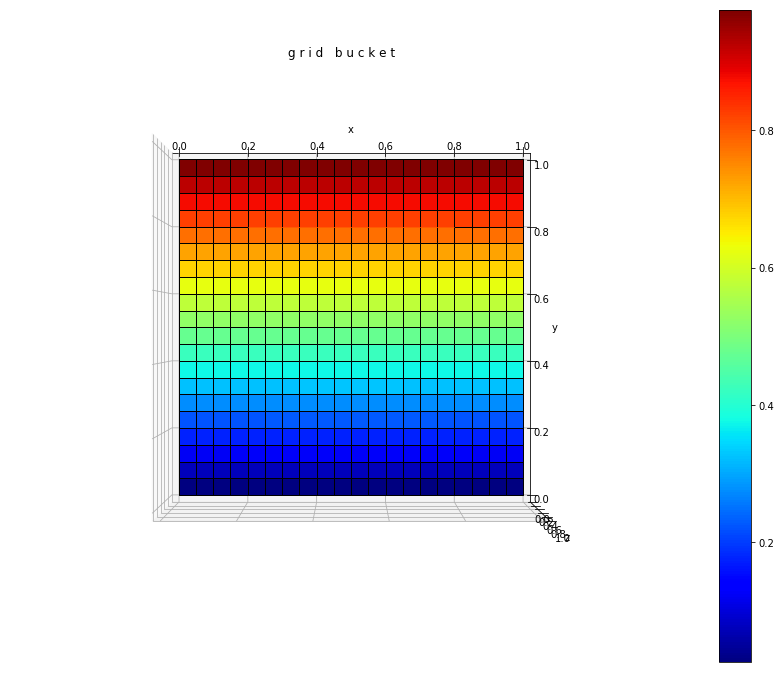

In [22]:
pp.plot_grid(gb, "pressure",figsize=(15, 12))